In [1]:
#from skfem import *

import numpy as np
import scipy
import skfem    # scikit-fem
#https://scikit-fem.readthedocs.io/en/latest/index.html

import matplotlib.pyplot as plt
import importlib  # for reloading routines
%matplotlib inline



### make a 2d triangle mesh using python's Delaunay routine. 

In [3]:
# evenly spaced points along a circular boundary  in 2d 
def mkcirc_boundary(n):
    dtheta = 2*np.pi/n
    circ_points = np.zeros((n,2))  
    #put points on circumference
    for i in range(n):
        x = np.cos(i*dtheta)
        y = np.sin(i*dtheta)
        circ_points[i,0] = x
        circ_points[i,1] = y
    return circ_points

# fill in the interior of the circle with radius 1
# with a random selection of points
# distance between each point must be greater than ds
# I am assuming you are passing the circle points as points
# new interior points will be appended to the points list
# calls routine min_dist_points() which is below
def mkcirc_interior(points,ds):
    radius = 1.0
    narea = int(np.pi*radius**2/ds**2)
    nfac = 10
    for i in range(narea*nfac):
        xnew = 2*np.random.uniform(-radius,radius)
        ynew = 2*np.random.uniform(-radius,radius)
        n_current = points.shape[0]
        r = np.sqrt(xnew**2 + ynew**2)
        if (r<radius):
            pnew = np.array([xnew,ynew])
            dr_mag = min_dist_points(pnew,points)  # find distance to closest other point
            if (dr_mag > ds):
                points = np.append(points, [pnew],axis=0)  # so that the format of the points array is ok
    return points

# find the minimum distance between point p0 and a list of points
# so you don't have any points too close to any other points 
def min_dist_points(p0,points):
    n_points = points.shape[0]
    #print(n_points)
    dr_mag_min = np.max(points)*2
    for i in range(0,n_points):
        dr_vec = np.squeeze(points[i,:]) - p0
        dr_mag = np.sqrt(np.sum(dr_vec**2))
        #print(dr_mag)
        if (dr_mag < dr_mag_min):
            dr_mag_min = dr_mag
    return dr_mag_min

# make a list of indices, one for each boundary point 
# for each boundary point, the index in the list is that of the closest interior point
def nearest_boundary_point(points,ncirc):
    n_points = points.shape[0]
    i_list = np.zeros(ncirc,dtype=int)
    d_list = np.zeros(ncirc) + 1000;
    for i in range(0,ncirc):  # loop over boundary
        pb = np.squeeze(points[i,:])
        for j in range(ncirc,n_points):  # loop over interior points 
            dr_vec = np.squeeze(points[j,:])- pb
            dr_mag = np.sqrt(np.sum(dr_vec**2))
            if (dr_mag < d_list[i]):
                d_list[i] = dr_mag
                i_list[i] = j
    return i_list 


In [5]:
# create a 2d triangular mesh in a circle using Delaunay triangle routine in scipy
# arguments:
#   ncirc , number of evenly spaced points on the circle
# returns:
#   points:  list of points, these are 2d format [i,0] is x of i-th point, [i,1] is y of i-th point
#   vertlist: list of points 3d 
#   trilist:  list of triangles from Delaunay triangulation of point cloud
#   tess: the triangle class output by the Delauney routine
def mk_circ_mesh(ncirc):
    circ_points = mkcirc_boundary(ncirc)   # make the evenly spaced boundary points
    ds = 2*np.pi/ncirc *0.8
    points = mkcirc_interior(circ_points,ds)  # fill interior points
    
    tess = scipy.spatial.Delaunay(points)  # make a triangular mesh with scipy's Delaunay routine 
    # extract our vertex and triangle list, convert points to 3d
    trilist = tess.simplices  # these are the triangles of the mesh
    
    fig, ax = plt.subplots(1,1,figsize=(3,3),dpi=200)
    ax.triplot(points[:,0], points[:,1], tess.simplices,markersize=2, marker='.',lw=1,color='orange',mfc='blue',mew=0)

    i_list = nearest_boundary_point(points,ncirc)  # return a list of nearest interior point to each boundary point
    
    return points,trilist,tess,i_list

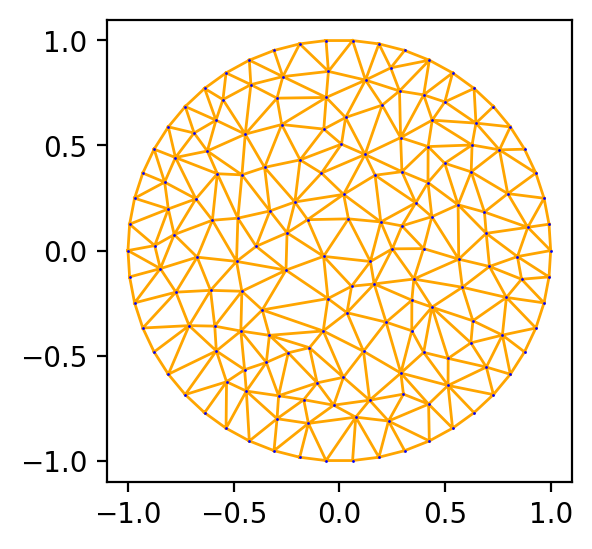

In [7]:
ncirc=50
points,trilist,tess,i_list = mk_circ_mesh(ncirc)

In [10]:
m = skfem.MeshTri(points.T,trilist.T)  #see if skfem will take it 

In [12]:
basis = skfem.CellBasis(m, skfem.ElementTriP1())  # see if skfem will make a basis, (yes)